# MESSI Cluster Analysis

Robert Wright | r.wright@fu-berlin.de

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from IPython.display import display
sns.set_theme() # changes more defaults

#os.environ['CARTOPY_USER_BACKGROUNDS'] = "./bg"

## DATA IMPORT AND TIDYING

Es werden zunächst die Standortdaten der DWD-Messstationen und der MESSIs eingelesen.

In [2]:
# import location of dwd stations
dwd_loc = pd.read_csv("../data/stationen_berlin_brandenburg.txt", delim_whitespace=True)

dwd_loc = (dwd_loc
    .drop(["von_datum", "bis_datum", "Bundesland"], axis="columns")
    .rename(columns = {"Stationshoehe": "alt", "geoBreite": "lat", "geoLaenge": "lon", "Stationsname": "station_name", "Stations_id": "id"})
)
dwd_loc["origin"] = "dwd"
dwd_loc

,id,alt,lat,lon,station_name,origin
0,399,36,52.5198,13.4057,Berlin-Alexanderplatz,dwd
1,400,60,52.6310,13.5021,Berlin-Buch,dwd
2,410,33,52.4040,13.7309,Berlin-Kaniswall,dwd
3,420,61,52.5447,13.5598,Berlin-Marzahn,dwd
4,427,46,52.3807,13.5306,Berlin-Brandenburg,dwd
5,430,36,52.5644,13.3088,Berlin-Tegel,dwd
6,433,48,52.4675,13.4021,Berlin-Tempelhof,dwd


In [3]:
# import location & altitude of messis
messi_loc = pd.read_csv("../data/messi_standorte.csv")
messi_loc = messi_loc.rename(columns = {"gauge_id": "id"})
messi_loc["origin"] = "messi"
messi_loc.to_csv("../data/messi_location_clean.csv", index=False)
messi_loc.head()

,id,lon,lat,alt,origin
0,2,13.33395,52.48429,42,messi
1,8,13.47643,52.44803,34,messi
2,9,13.31014,52.45784,72,messi
3,13,13.55526,52.55220,52,messi
4,17,13.52497,52.45489,34,messi


Der _dataframe_ mit den Temperaturmessungen wird in das _tidy format_ gebracht und dann werden mithilfe der Stations-IDs die jeweiligen Standortdaten hinzugefügt.

In [4]:
# import temperature data and parse measurement time as datetime object
meas = pd.read_csv("../data/data.csv", parse_dates=["time_measured"])
meas = meas.melt(id_vars="time_measured", var_name="id", value_name="tmp")
meas['id'] = meas["id"].astype(int)
# focus on august (remove last value of 2022-09-01 00:00:00, which is technically december)
meas = meas[meas.time_measured.dt.month == 8]
meas.tail()


,time_measured,id,tmp
178594,2022-08-31 23:10:00,420,15.1
178595,2022-08-31 23:20:00,420,15.0
178596,2022-08-31 23:30:00,420,14.9
178597,2022-08-31 23:40:00,420,14.8
178598,2022-08-31 23:50:00,420,14.8


In [5]:
# https://stackoverflow.com/questions/54487745/how-to-merge-pandas-dataframes-without-duplicating-columns
tmp_raw = meas.merge(right=pd.concat([messi_loc, dwd_loc], axis="index"), how="left", on="id")
# add day column
tmp_raw["day"] = tmp_raw["time_measured"].dt.day
tmp_raw.head()

,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
0,2022-08-01 00:00:00,2,21.690,13.33395,52.48429,42.0,messi,NaN,1
1,2022-08-01 00:10:00,2,21.530,13.33395,52.48429,42.0,messi,NaN,1
2,2022-08-01 00:20:00,2,21.260,13.33395,52.48429,42.0,messi,NaN,1
3,2022-08-01 00:30:00,2,21.075,13.33395,52.48429,42.0,messi,NaN,1
4,2022-08-01 00:40:00,2,21.030,13.33395,52.48429,42.0,messi,NaN,1


## PRELIMINARY ANALYSIS

In [6]:
tmp_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178560 entries, 0 to 178559
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   time_measured  178560 non-null  datetime64[ns]
 1   id             178560 non-null  int64         
 2   tmp            113759 non-null  float64       
 3   lon            160704 non-null  float64       
 4   lat            160704 non-null  float64       
 5   alt            160704 non-null  float64       
 6   origin         160704 non-null  object        
 7   station_name   17856 non-null   object        
 8   day            178560 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 13.6+ MB


Anscheinend gibt es ein paar IDs in `data.csv`, bei denen keine Temperaturwerte und Standortdaten vorliegen, daher die unterschiedliche Anzahl an Eintragungen in _id_ und den Spalten der Umgebungsvariablen.

### Missing Values

In [7]:
# some messis do not have any (location) data
nmessi = tmp_raw["id"][tmp_raw.lat.isna()].drop_duplicates().values

for n in nmessi:
    id = tmp_raw[tmp_raw.id == n]
    print(f"# id = {n}\ndifferent tmp values:", id["tmp"].drop_duplicates().values)
    display(id[~id.tmp.isna()])

# remove these messis
tmp_raw = tmp_raw[~tmp_raw.id.isin(nmessi)]

# id = 15
different tmp values: [nan]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day


# id = 58
different tmp values: [    nan 26.5527]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
103786,2022-08-08 17:40:00,58,26.5527,NaN,NaN,NaN,NaN,NaN,8


# id = 76
different tmp values: [   nan 19.995 19.86 ]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
134355,2022-08-04 00:30:00,76,19.995,NaN,NaN,NaN,NaN,NaN,4
134357,2022-08-04 00:50:00,76,19.860,NaN,NaN,NaN,NaN,NaN,4


# id = 79
different tmp values: [    nan 25.7666]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
138922,2022-08-04 17:40:00,79,25.7666,NaN,NaN,NaN,NaN,NaN,4


Das Fehlen der Temperaturwerte nehme ich zum Anlass, die Anzahl der *missing values* für jeden MESSI herauszufinden.

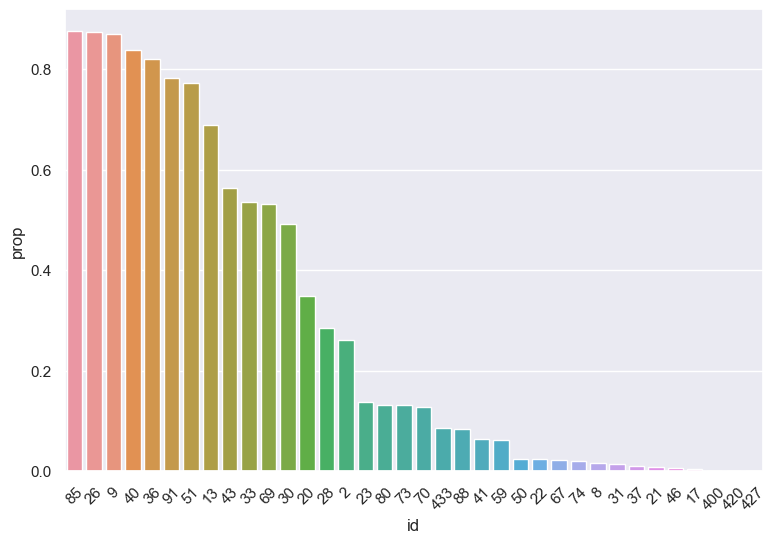

In [8]:
# number of nans per messi
# https://stackoverflow.com/questions/53947196/groupby-class-and-count-missing-values-in-features
nans_id = (tmp_raw
    .isna()
    .groupby(tmp_raw.id)[['tmp']]
    .sum()
    .sort_values(by="tmp", ascending=False)
    .reset_index()
)
# number of time steps (i.e., rows) per messi (highest possible number of nans)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.size.html
nans_id["total"] = tmp_raw.groupby(["id"]).size().values[0]
# compute proportion of missing values
nans_id["prop"] = nans_id.tmp / nans_id.total
# convert to string for descending bar plot
nans_id["id"] = nans_id["id"].astype(str)

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=nans_id, x="id", y="prop", ax=ax)
ax.tick_params(axis="x", rotation=45)

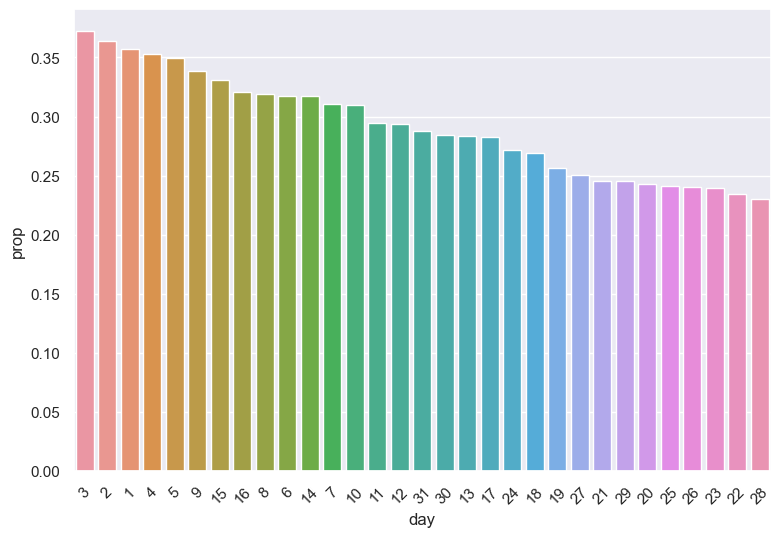

In [9]:
# number of nans per day
nans_day = (tmp_raw
    .isna()
    .groupby(tmp_raw.day)[['tmp']]
    .sum()
    .sort_values(by="tmp", ascending=False)
    .reset_index()
)
# number of time steps per messi (highest possible number of nans)
nans_day["total"] = tmp_raw.groupby(["day"]).size().values[0]
# compute proportion of missing values
nans_day["prop"] = nans_day.tmp / nans_day.total
# convert to string for descending bar plot
nans_day["day"] = nans_day["day"].astype(str)

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=nans_day, x="day", y="prop", ax=ax)
ax.tick_params(axis="x", rotation=45)

Der **23. August** ist ein geeigneter Tag für die erste Cluster Analysis, da er wenige fehlende Werte hat, aber keine komisch-wirkenden Messungen einzelner MESSIs (vergleiche monatlichen Temperaturverlauf der MESSIs weiter unten im gleichen Abschnitt).

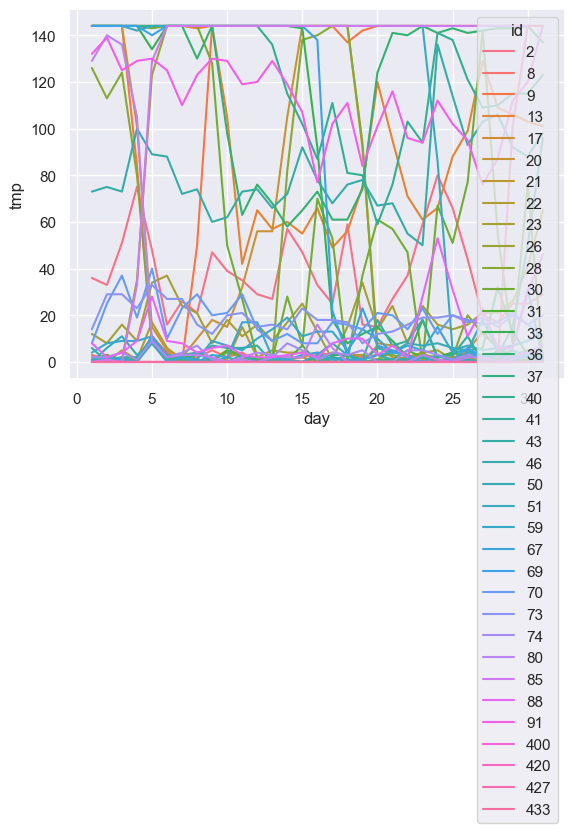

In [10]:
# temporal evolution: number of nans per day & messi
nans_tevol = (tmp_raw
    .isna()
    .groupby([tmp_raw.day, tmp_raw.id])[['tmp']]
    .sum()
    .reset_index()
)

# convert to string so that seaborn treats it as a categorical variable
nans_tevol["id"] = nans_tevol["id"].astype(str)

sns.lineplot(data=nans_tevol, x="day", y="tmp", hue="id");

***

Der Temperturverlauf der einzelnen Messpunkte wird dargestellt. Wie bereits erwähnt, fehlen bei einigen MESSIs Datenpunkte, deshalb sind "unschöne" Linien zu erkennen.

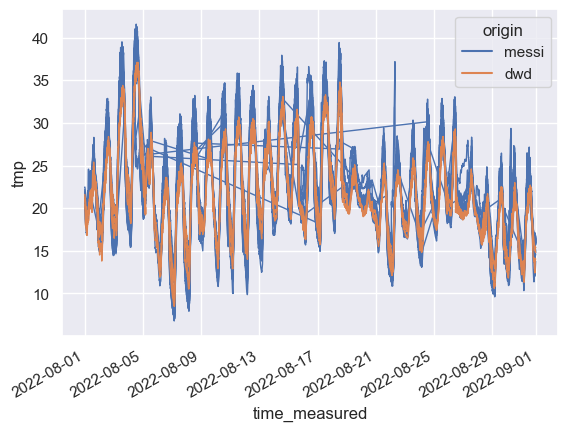

In [11]:
# temperature values
fig, ax = plt.subplots()
sns.lineplot(data=tmp_raw, x="time_measured", y="tmp", hue="origin", units="id", estimator=None, lw=1, ax=ax)
fig.autofmt_xdate()
fig.savefig("../figs/tmp-verlauf.png", dpi=300, bbox_inches="tight")

*Erstelle eine Karte von Berlin in der die Standorte der MESSIs und der DWD-Stationen ersichtlich sind (MESSI- und DWD-Stationen voneinander unterscheidbar)*

Die Standorte der DWD-Messstationen und der MESSIs sind dargestellt. Das Hintergrundbild kann mit der entsprechenden `cartopy.io.img_tiles`-Funktion angepasst werden. Soweit sah (leider) Google Maps am besten aus.

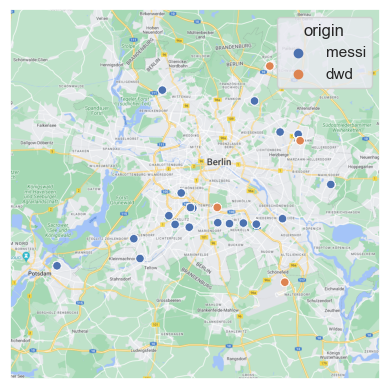

In [12]:
# locations
# https://scitools.org.uk/cartopy/docs/v0.18/cartopy/io/img_tiles.html
# https://docs.dkrz.de/doc/visualization/sw/python/source_code/python-matplotlib-example-high-resolution-background-image-plot.html

trans = ccrs.PlateCarree() # do not change!
request = cimgt.GoogleTiles() # zoom level = 11
#request = cimgt.OSM() # zoom level = 10
#request = cimgt.Stamen(style="watercolor") # zoom level = 10
#extent = [10, 15, 50, 55]  # (xmin, xmax, ymin, ymax)

fig, ax = plt.subplots(subplot_kw={"projection": request.crs})
sns.scatterplot(data=tmp_raw, x="lon", y="lat", hue="origin", transform=trans, ax=ax)
#ax.scatter(tmp_raw.lon, tmp_raw.lat, transform=trans) # faster plotting for debugging
ax.add_image(request, 11, alpha=0.9) 

fig.savefig("../figs/locations.png", dpi=300, bbox_inches="tight")

Gibt es MESSIs, die sehr nah beieinander sind und auf der obigen Karte nicht aufgelöst werden können?

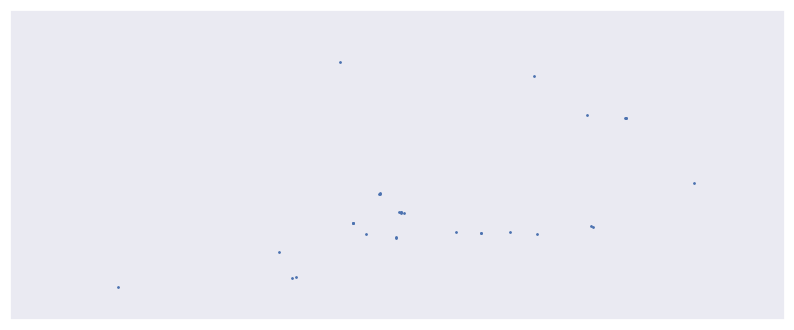

In [13]:
# filter out dwd stations
data = tmp_raw[tmp_raw.origin == "messi"][["id", "lon", "lat"]].drop_duplicates()

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection": crs})
ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=crs)
ax.scatter(data.lon, data.lat, transform=crs, s=1);
#ax.gridlines(draw_labels=True, dms=True)

# some MESSIs are really close together!

In [14]:
# TODO
# - Die störenden Linien aus dem seaborn plot entfernen, siehe:
#   https://stackoverflow.com/a/74195610
# - Wenn die "day" column im Datensatz mit den Temperaturwerten herangezogen wird,
#   funktioniert diese Analyse nur für einen einzigen Monat

In [15]:
# TODO:
# - Wie könnte man Outlier erkennen? Regression & residuals plotten?
# - Methode mit fehlenden Werten umzugehen: Mindestanzahl an Temperaturwerten pro Tag (!),
#   damit MESSI berücksichtigt wird? Oder Mindestanzahl über den ganzen Messzeitraum?
# - Warum keine Daten vom Wetterturm?
# - Auf den Süden von Berlin konzentrieren, weil dort mehr MESSIs sind?

## CLUSTER ANALYSIS

In [16]:
# TODO
# - Nochmal wegen features fragen: Was bringt der Bezug auf die DWD-Tagesmitteltemperatur?
# - Bisher keine Kalibrierung der Messdaten?
#   Nein, könnte nur berechnet werden, indem ein MESSI neben eine DWD-Station platziert wird.
# - Höhe erstmal weglassen, um zu gucken, ob gefundene Cluster dann mit der Höhe übereinstimmen?
# - Anzahl der fehlenden Werte als "random feature" reinpacken? Vielleicht kann man
#   die importance der features berechnen und sieht, wie viel das ausmacht, was eigentlich
#   nichts ausmachen sollte...
# - std und diff sind stark korreliert, könnte man sich eigentlich eins sparen

*Verwende die DWD-Stationen, um für jeden Tag die Tagesmitteltemperatur zu schätzen.
Bei den MESSI-Werten interessiert uns dann statt der gegebenen Messwerte in °C die
Abweichung $ \Delta T $ von der geschätzten Tagesmitteltemperatur.*

In [17]:
# compute daily mean temperature of dwd stations and merge with tmp dataset
dwd_mean = (tmp_raw
    [tmp_raw.origin == "dwd"]
    .groupby("day", as_index=False)
    ["tmp"].mean()
    .rename(columns = {"tmp": "dwd_mean"})
)
dwd_mean

tmp_dev = (tmp_raw
    [tmp_raw.origin == "messi"] # filter dwd stations!
    .merge(right=dwd_mean, on="day")
)

# compute deviation from daily dwd mean for every messi
tmp_dev["dev"] = tmp_dev["tmp"] - tmp_dev["dwd_mean"]

tmp_dev # 10min temporal resolution!

,time_measured,id,tmp,lon,lat,alt,origin,station_name,day,dwd_mean,dev
0,2022-08-01 00:00:00,2,21.690,13.33395,52.48429,42.0,messi,NaN,1,20.679340,1.01066
1,2022-08-01 00:10:00,2,21.530,13.33395,52.48429,42.0,messi,NaN,1,20.679340,0.85066
2,2022-08-01 00:20:00,2,21.260,13.33395,52.48429,42.0,messi,NaN,1,20.679340,0.58066
3,2022-08-01 00:30:00,2,21.075,13.33395,52.48429,42.0,messi,NaN,1,20.679340,0.39566
4,2022-08-01 00:40:00,2,21.030,13.33395,52.48429,42.0,messi,NaN,1,20.679340,0.35066
...,...,...,...,...,...,...,...,...,...,...,...
142843,2022-08-31 23:10:00,91,NaN,13.09720,52.39973,40.0,messi,NaN,31,17.039583,NaN
142844,2022-08-31 23:20:00,91,NaN,13.09720,52.39973,40.0,messi,NaN,31,17.039583,NaN
142845,2022-08-31 23:30:00,91,NaN,13.09720,52.39973,40.0,messi,NaN,31,17.039583,NaN
142846,2022-08-31 23:40:00,91,NaN,13.09720,52.39973,40.0,messi,NaN,31,17.039583,NaN


### Feature Engineering

_Erzeuge dann für jeden MESSI und jeden Tag einen Punkt in einem Raum mit folgenden Dimensionen:_
- Differenz der Tageshöchst- und tiefstwerte $  \Delta T_{max} - \Delta T_{min} $ 
- Arithmetisches Mittel $  \overline{\Delta T} $
- Standardabweichung $  \sigma  \Delta T $
- ggf. weitere selbst erdachte sinnvolle Dimensionen

In [18]:
# features are created on daily temporal resolution

# 1) difference of max and min deviation
# add maximum deviation
tmp_ftrs = (tmp_dev
    .groupby(["day", "id", "alt"], as_index=False) # here, grouping by altitude
    ["dev"].max()                                  # is kind of a hack to keep the column
    .rename(columns = {"dev": "dmax"})             # (there's just one alt per id)
)
# add minimum deviation
tmp_ftrs["dmin"] = tmp_dev.groupby(["day", "id"])["dev"].min().values
# difference
tmp_ftrs["diff"] = tmp_ftrs["dmax"] - tmp_ftrs["dmin"]

# 2) mean daily deviation
tmp_ftrs["mean"] = tmp_dev.groupby(["day", "id"])["dev"].mean().values

# 3) standard deviation of daily deviation
tmp_ftrs["std"] = tmp_dev.groupby(["day", "id"])["dev"].std().values

# add number of missing values per day & messi
tmp_ftrs["nans"] = tmp_dev.isna().groupby([tmp_dev.day, tmp_dev.id], as_index=False)["tmp"].sum()

tmp_ftrs.to_csv("../data/tmp_ftrs.csv", index=False)
tmp_ftrs

,day,id,alt,dmax,dmin,diff,mean,std,nans
0,1,2,42.0,4.845660,-2.964340,7.810,0.607697,2.018889,36
1,1,8,34.0,7.020660,-4.199340,11.220,0.838674,2.091451,3
2,1,9,72.0,NaN,NaN,NaN,NaN,NaN,144
3,1,13,52.0,NaN,NaN,NaN,NaN,NaN,144
4,1,17,34.0,4.745660,-1.434340,6.180,1.225278,1.485958,0
...,...,...,...,...,...,...,...,...,...
987,31,74,42.0,8.550417,-3.669583,12.220,1.449417,3.603771,4
988,31,80,40.0,7.615417,-4.459583,12.075,1.173081,3.568107,7
989,31,85,72.0,NaN,NaN,NaN,NaN,NaN,144
990,31,88,44.0,8.945417,-4.584583,13.530,2.054192,3.760315,46


**RECAP: box and whisker plot**

From [matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html):

The box extends from the first [quartile](https://en.wikipedia.org/wiki/Quartile) (Q1) to the third quartile (Q3) of the data, with a line at the median. The whiskers extend from the box by 1.5x the [inter-quartile range](https://en.wikipedia.org/wiki/Interquartile_range) (IQR). Because the whiskers must end at an observed data point, the whisker lengths can look unequal, even though 1.5x IQR is the same for both sides. Flier points are those past the end of the whiskers.

```
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|
flier             <----------->            fliers
                       IQR
```

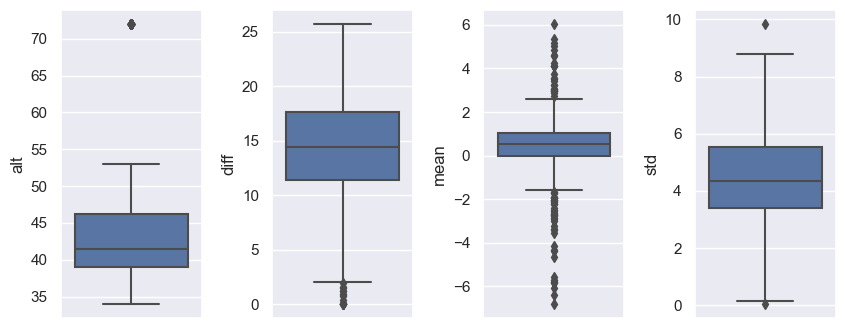

In [19]:
# boxplot
cols = ["alt", "diff", "mean", "std"]

fig, axs = plt.subplots(1, len(cols), figsize=(10,4), gridspec_kw={"wspace": 0.5})
for i, ftr in enumerate(cols):
    sns.boxplot(data=tmp_ftrs, y=ftr, ax=axs[i])

### Feature correlation

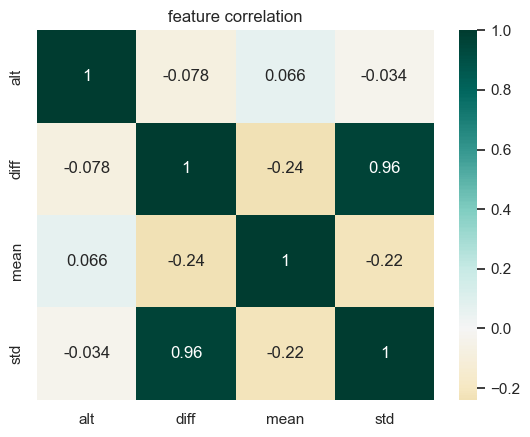

In [20]:
cols = ["alt", "diff", "mean", "std"]

# .corr() method computes pairwise correlation of columns
data = tmp_ftrs[cols].corr(method="pearson")

fig, ax = plt.subplots()
sns.heatmap(data=data, annot=True, cmap="BrBG", center=0.0, ax=ax)
ax.set_title("feature correlation")
fig.savefig("../figs/feature-corr.png", dpi=300, bbox_inches="tight")

Erwartungsgemäß sind `diff` und `std` stark korreliert. Erstaunlicherweise korreliert die Höhe mit
keinem der übrigen features.

### K-means


From [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#k-means):

K-means is often referred to as Lloyd's algorithm. In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose samples from the dataset . After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.

#### Single day, default features

Die erste Cluster-Analyse wird am 23. August durchgeführt, als feature werden `diff`,
`mean` und `std` benutzt.

In [21]:
# let's start with 23 Aug (small number of missing values)
ftrs = ["diff", "mean", "std"]

# kmeans cannot handle missing values, rows containing missing values are going
# to be removed
day23 = tmp_ftrs[tmp_ftrs.day == 23].dropna()
day23_ftrs = day23[ftrs].values # convert to numpy array

Beim `KMeans`-Algorithmus wird die Anzahl der Cluster vorher festgelegt. Um eine
geeignete Anzahl an Clustern zu finden, eignet sich die [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

In [22]:
from sklearn.cluster import KMeans

# compute kmean for multiple numbers of cluster, follow this approach:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

sse = {}
for k in range(1,11):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++", # initializes the centroids to be (generally) distant from each other
        n_init=10,        # # of times kmeans is run with different centroid seeds
        random_state=42,  # for reproducibility
    ).fit(         # here, compute k-means clustering
        day23_ftrs # <- shape (n_samples, n_features)
    )
    # output some information
    print(
        "# of clusters", k,
        "\t# of iterations:", kmeans.n_iter_,
        "\t# of features:", kmeans.n_features_in_
    )
    # and save evaluation metric
    sse[k] = kmeans.inertia_ # sum of squared distances

# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 2 	# of features: 3
# of clusters 3 	# of iterations: 3 	# of features: 3
# of clusters 4 	# of iterations: 5 	# of features: 3
# of clusters 5 	# of iterations: 3 	# of features: 3
# of clusters 6 	# of iterations: 3 	# of features: 3
# of clusters 7 	# of iterations: 2 	# of features: 3
# of clusters 8 	# of iterations: 5 	# of features: 3
# of clusters 9 	# of iterations: 2 	# of features: 3
# of clusters 10 	# of iterations: 5 	# of features: 3


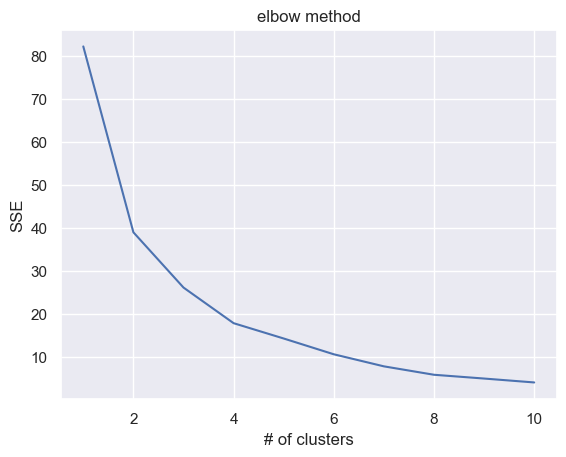

In [23]:
fig, ax = plt.subplots()
ax.plot(list(sse.keys()), list(sse.values()))
ax.set_title("elbow method")
ax.set_xlabel("# of clusters")
ax.set_ylabel("SSE");
fig.savefig("../figs/elbow.png", dpi=300, bbox_inches="tight")

Es sieht so aus, als läge der "Knick" bei **vier** Clustern.

***

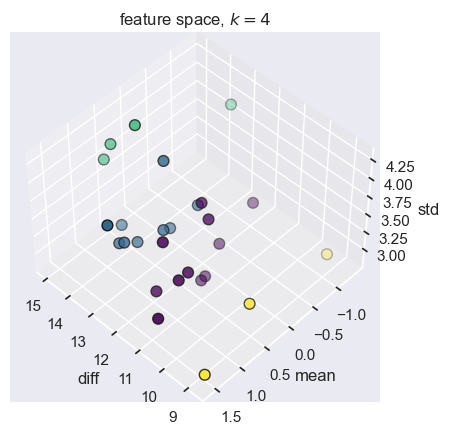

In [24]:
# repeat kmeans with 4 clusters
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42).fit(day23_ftrs)

# and visualise clusters in feature space
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "elev": 48, "azim": 134})
ax.scatter(day23_ftrs[:, 0], day23_ftrs[:, 1], day23_ftrs[:, 2],
           c=kmeans.labels_, edgecolor="k", cmap="viridis", s=60)
ax.set_xlabel(ftrs[0])
ax.set_ylabel(ftrs[1])
ax.set_zlabel(ftrs[2])
ax.set_title(r"feature space, $k=4$")
fig.savefig("../figs/feature-space.png", dpi=300, bbox_inches="tight")

# add cluster centers to this plot?

Womöglich sehen die Cluster "länglich" aus, da `diff` und `std` stark korrelieren und damit als "doppeltes" feature in den Cluster-Algorithmus eingehen.

#### Einschub: # of NaNs als weights

In [25]:
# compute weights
nans = tmp_ftrs[tmp_ftrs.day == 23].dropna()["nans"].values
wghts = 1 - (nans / 144)

# alternative approaches for scaling weights
wghts_ = 10 - (nans / 14.4)
wghts__ = np.max(nans) - nans

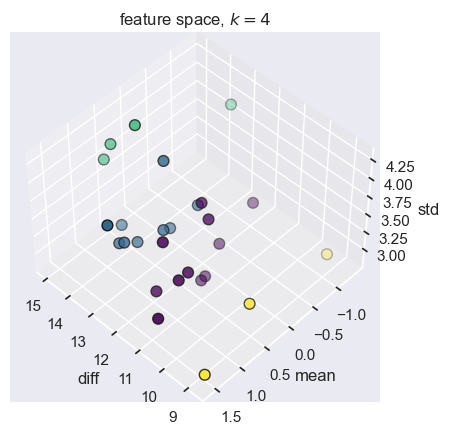

In [26]:
# repeat kmeans with 4 clusters & weights
kmeans_wghts = KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42).fit(day23_ftrs, sample_weight=wghts)

fig, ax = plt.subplots(subplot_kw={"projection": "3d", "elev": 48, "azim": 134})
ax.scatter(day23_ftrs[:, 0], day23_ftrs[:, 1], day23_ftrs[:, 2],
           c=kmeans_wghts.labels_, edgecolor="k", cmap="viridis", s=60)
ax.set_xlabel(ftrs[0])
ax.set_ylabel(ftrs[1])
ax.set_zlabel(ftrs[2])
ax.set_title(r"feature space, $k=4$");

Das Hinzufügen von weights (d.h. die Datenpunkte werden unterschiedlich gewichtet) verändert die Cluster (auch unter Berücksichtigung verschiedener Skalierungen) am 23. August nicht.

***

Abschließend können die Cluster auf räumlicher Ebene dargestellt werden.

In [27]:
# the order of messis does not change, hence, adding labels to dataframe is as simple as:
day23["label"] = kmeans.labels_
# add messi location data -> new data frame for plotting section
data = day23.merge(right=messi_loc[["id", "lon", "lat"]], how="left", on="id")

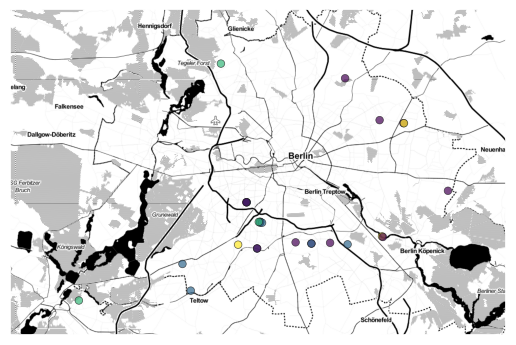

In [28]:
# plotting...
trans = ccrs.PlateCarree() # do not change!
bg = cimgt.Stamen(style="toner") # background map

fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)
ax.scatter(data["lon"], data["lat"], c=data["label"], 
           s=30, alpha=0.7, edgecolor="k", linewidth=0.5, cmap="viridis", transform=trans)
ax.add_image(bg, 11) 

# I can't plot markers according to # of cluster...

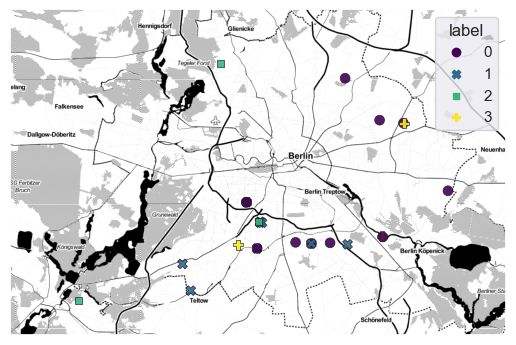

In [29]:
# it works with seaborn and "style"-attribute though...

trans = ccrs.PlateCarree() # do not change!
bg = cimgt.Stamen(style="toner") # background map

fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)
sns.scatterplot(data=data, x="lon", y="lat", hue="label", style="label", palette="viridis",
                s=50, linewidth=0.5, ec="k", alpha=0.9, transform=trans, ax=ax) #legend=False
ax.add_image(bg, 11) 
fig.savefig("../figs/loc-cluster.png", dpi=300, bbox_inches="tight")

Ein paar (einfache) weitere Informationen über die gefundenen Cluster:

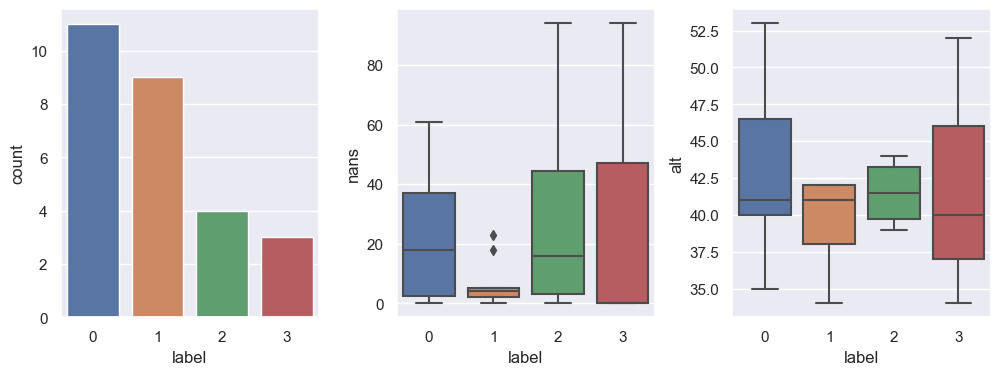

In [37]:
data = day23

fig, ax = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={"wspace": 0.3})
sns.countplot(data=data, x="label", ax=ax[0])
sns.boxplot(data=data, x="label", y="nans", ax=ax[1])
sns.boxplot(data=data, x="label", y="alt", ax=ax[2]);

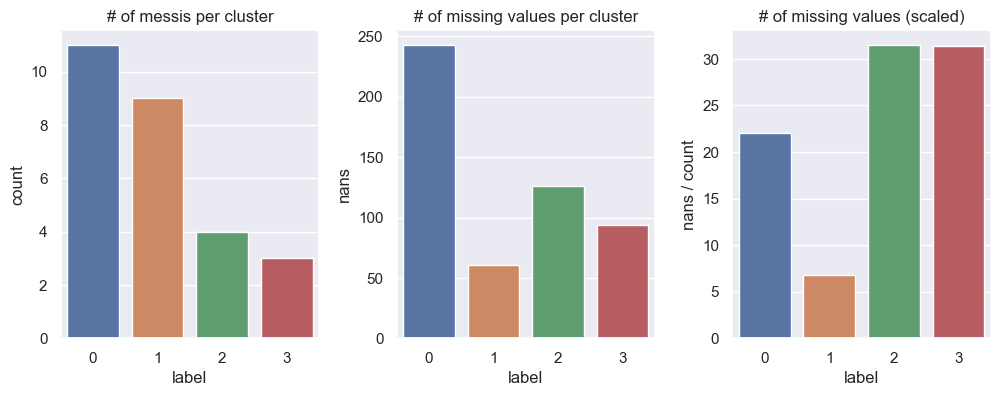

In [31]:
data = day23.groupby("label", as_index=False)[["nans"]].sum()
data["count"] = day23.groupby("label")["id"].count().values
data["nans_adj"] = data["nans"] / data["count"]

fig, axs = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={"wspace": 0.3})
sns.barplot(data=data, x="label", y="count", ax=axs[0])
axs[0].set_title("# of messis per cluster")
sns.barplot(data=data, x="label", y="nans", ax=axs[1])
axs[1].set_title("# of missing values per cluster")
sns.barplot(data=data, x="label", y="nans_adj", ax=axs[2])
axs[2].set_title("# of missing values (scaled)")
axs[2].set_ylabel("nans / count");

***

Die Cluster-Analyse wird mit $k=2$ (Anzahl der Cluster) wiederholt, da dies auch ein "Ellenbogen" sein könnte. 

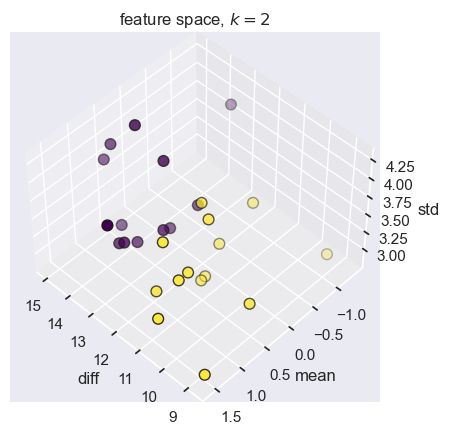

In [32]:
# 2 clusters
k = 2
kmeans2 = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42).fit(day23_ftrs)

# visualise clusters in feature space
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "elev": 48, "azim": 134})
ax.scatter(day23_ftrs[:, 0], day23_ftrs[:, 1], day23_ftrs[:, 2],
           c=kmeans2.labels_, edgecolor="k", cmap="viridis", s=60)
ax.set_xlabel(ftrs[0])
ax.set_ylabel(ftrs[1])
ax.set_zlabel(ftrs[2])
ax.set_title(rf"feature space, $k={k}$");

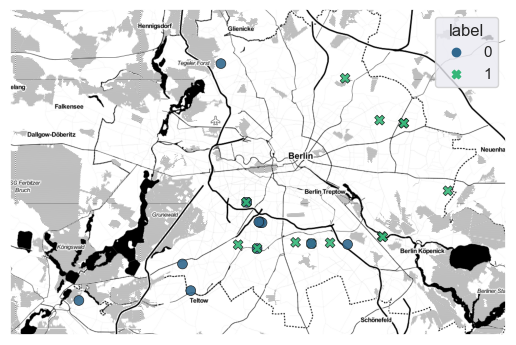

In [36]:
day23["label"] = kmeans2.labels_
data = day23.merge(right=messi_loc[["id", "lon", "lat"]], how="left", on="id")

trans = ccrs.PlateCarree() # do not change!
bg = cimgt.Stamen(style="toner") # background map

fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)
sns.scatterplot(data=data, x="lon", y="lat", hue="label", style="label", palette="viridis",
                s=50, linewidth=0.5, ec="k", alpha=0.9, transform=trans, ax=ax) #legend=False
ax.add_image(bg, 11)
fig.savefig("../figs/loc-cluster-2.png", dpi=300, bbox_inches="tight")

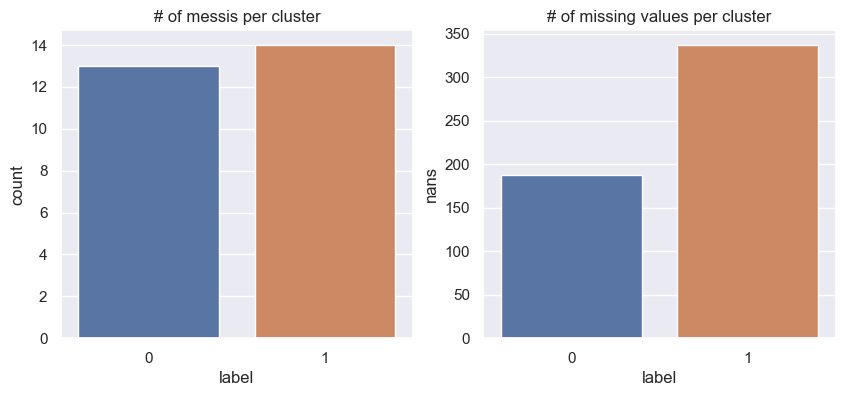

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(data=data, x="label", ax=axs[0])
axs[0].set_title("# of messis per cluster")
sns.barplot(data=data, x="label", y="nans", estimator="sum", errorbar=None, ax=axs[1])
axs[1].set_title("# of missing values per cluster");